In [51]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [52]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

In [53]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [54]:
env.P[0,:,0]

array([0.85, 0.15, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

In [55]:
from plotter import plot_gridworld

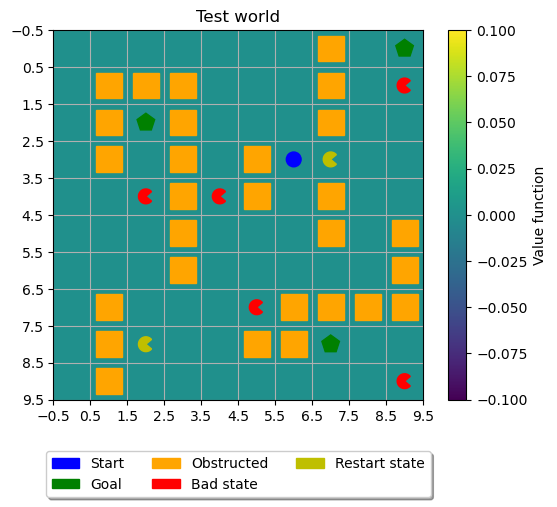

In [56]:
plot_gridworld(env, title="Test world")

In [73]:
from Algorithms import sarsa

In [74]:
q_function, pi, state_counts,steps,rewards = sarsa(env, alpha=0.9, epsilon=0.2, maxiter=100, maxeps=10000)

Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Running episode 5000.
Running episode 6000.
Running episode 7000.
Running episode 8000.
Running episode 9000.


In [59]:
len(steps)

10000

In [75]:
num_expts = 5
total_rewards, total_steps = [], []

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = sarsa(env, alpha=0.9, epsilon=0.2, maxiter=100, maxeps=10000)
    total_steps.append(steps)
    total_rewards.append(rewards)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Running episode 5000.
Running episode 6000.
Running episode 7000.
Running episode 8000.
Running episode 9000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Running episode 5000.
Running episode 6000.
Running episode 7000.
Running episode 8000.
Running episode 9000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Running episode 5000.
Running episode 6000.
Running episode 7000.
Running episode 8000.
Running episode 9000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Running episode 5000.
Running episode 6000.
Running episode 7000.
Running episode 8000.
Running episode 9000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.

In [61]:
print(len(total_steps))
print(len(total_steps[0]))
print(len(total_rewards))
print((total_rewards[0]))

5
10000
5
[-605, -144, -226, -199, -338, -125, -496, -199, -219, -100, -105, -199, -298, -115, -58, -72, -69, -209, -49, -115, -115, -120, -82, -76, -201, -380, -105, -204, -51, -170, -43, -209, -397, -40, -298, -208, -31, -99, -219, -177, -199, -100, -209, -150, -59, -234, -249, -115, -100, -100, -106, -492, -100, -72, -57, -48, -60, -209, -204, -19, -161, -90, -100, -93, -90, -115, -189, -219, -51, -214, -51, -152, -70, -29, -93, -154, -43, -239, -402, -71, -100, -318, -26, -54, -30, -45, -29, -105, -110, -116, -60, -59, -40, -303, -38, -155, -43, -36, -27, -25, -125, -100, -110, -24, -100, -496, -127, -100, -67, -101, -19, -38, -28, -265, -110, -298, -146, -80, -30, -75, -140, -53, -50, -51, -105, -78, -84, -121, -145, -84, -181, -147, -37, -295, -385, -71, -183, -58, -43, -78, -41, -93, -37, -139, -58, -282, -48, -145, -43, -141, -30, -57, -35, -141, -32, -33, -51, -26, -72, -174, -67, -51, -46, -167, -26, -153, -65, -72, -61, -155, -110, -45, -63, -39, -29, -21, -19, -24, -149, -5

In [62]:
total_steps

[[100,
  40,
  87,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  38,
  72,
  39,
  100,
  34,
  100,
  100,
  100,
  62,
  56,
  97,
  78,
  100,
  100,
  51,
  100,
  38,
  100,
  100,
  35,
  100,
  84,
  26,
  94,
  100,
  73,
  100,
  100,
  100,
  46,
  54,
  26,
  100,
  100,
  100,
  100,
  76,
  81,
  100,
  62,
  52,
  48,
  45,
  90,
  100,
  19,
  57,
  85,
  100,
  88,
  85,
  65,
  50,
  100,
  46,
  100,
  31,
  48,
  50,
  29,
  63,
  55,
  33,
  100,
  100,
  61,
  100,
  100,
  26,
  44,
  30,
  45,
  29,
  100,
  100,
  86,
  55,
  49,
  30,
  100,
  33,
  46,
  33,
  31,
  27,
  20,
  100,
  100,
  100,
  24,
  100,
  100,
  87,
  100,
  42,
  66,
  19,
  23,
  23,
  62,
  100,
  100,
  37,
  70,
  25,
  70,
  100,
  43,
  50,
  46,
  100,
  78,
  74,
  91,
  36,
  74,
  77,
  43,
  22,
  87,
  83,
  61,
  79,
  53,
  38,
  73,
  41,
  93,
  32,
  35,
  53,
  79,
  48,
  41,
  43,
  42,
  30,
  52,
  35,
  42,
  27,
  33,
  41,
  21,


In [76]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

In [77]:
len(avg_rewards)

10000

In [78]:
len(std_across_rewards)

10000

In [79]:
import matplotlib.pyplot as plt

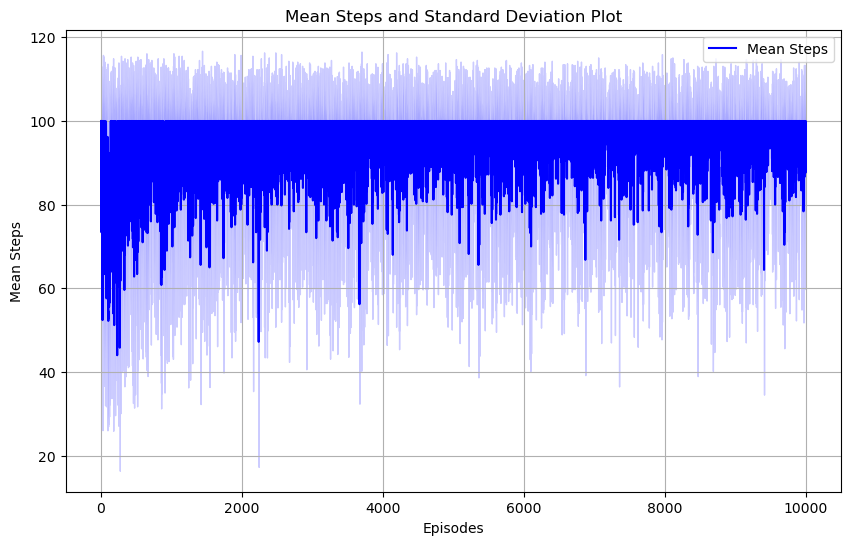

ValueError: 'y1' is not 1-dimensional

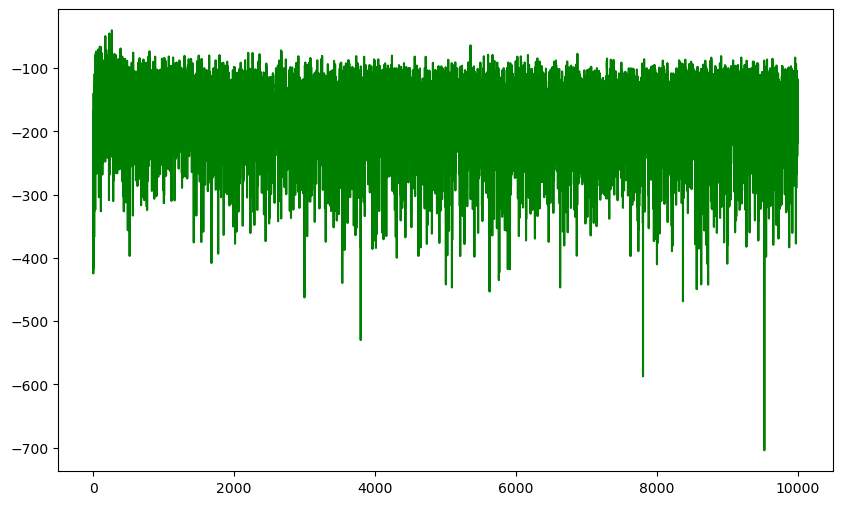

In [81]:
episodes = np.arange(1, len(avg_steps) + 1)

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(episodes, avg_steps, label='Mean Steps', color='blue')
plt.fill_between(episodes, avg_steps - std_across_steps, avg_steps + std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(episodes, avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(episodes, avg_rewards - std_across_rewards, avg_rewards + std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
state_counts[:,0].reshape(10,10)

array([[ 6918.,  7691.,  7123.,  6952.,  7533.,  6342.,  4759.,     0.,
         4048.,     0.],
       [ 6638.,     0.,     0.,     0.,  7772.,  7867.,  7474.,     0.,
         7147.,  4239.],
       [ 6761.,     0.,     0.,     0.,  9363., 10492., 14825.,     0.,
         6726.,  7948.],
       [ 7646.,     0.,  3275.,     0.,  7637.,     0., 41214.,  4163.,
         6894., 10765.],
       [ 6926.,  6134.,  4321.,     0.,  5835.,     0., 23677.,     0.,
        11044.,  7369.],
       [ 4330.,  4769.,  4887.,     0., 13221., 15903., 22567.,     0.,
        13481.,     0.],
       [ 2346.,  3269.,  4841.,     0., 15833., 11224., 16933., 16577.,
        14257.,     0.],
       [  956.,     0.,  3033.,  7816., 11370.,  4308.,     0.,     0.,
            0.,     0.],
       [  487.,     0.,   688.,  4891.,  9576.,     0.,     0.,     0.,
          834.,   382.],
       [  304.,     0.,  1006.,  2777.,  8609.,  8705.,  9715.,  6315.,
         2001.,   317.]])

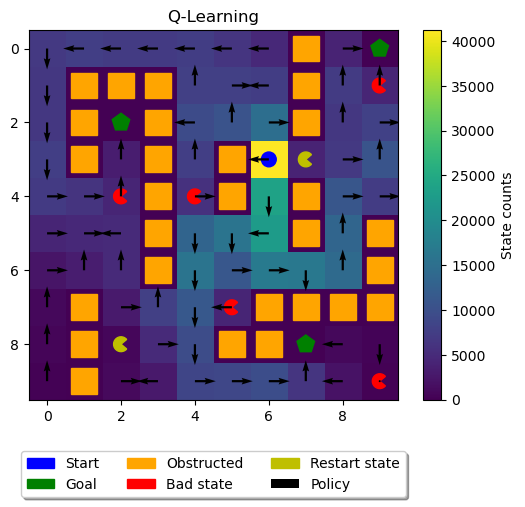

In [69]:
plot_gridworld(env, policy=pi, state_counts=state_counts, title="Q-Learning")

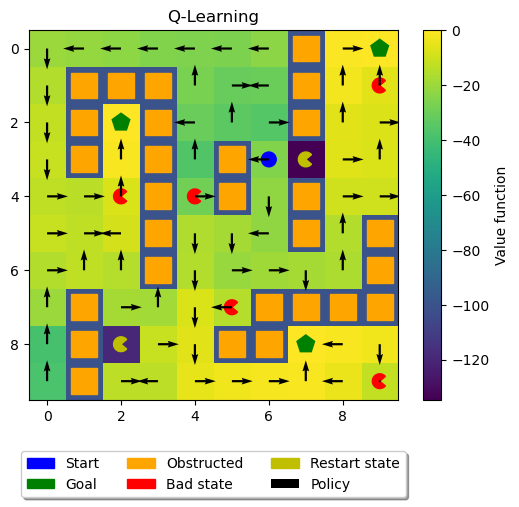

In [70]:
plot_gridworld(env,policy=pi,value_function=q_function, title="Q-Learning")

In [71]:
from Algorithms import sarsa

In [72]:
q_function_s, pi, state_counts = sarsa(env, alpha=0.1, epsilon=0.2, maxiter=100, maxeps=100000)


Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Running episode 5000.
Running episode 6000.
Running episode 7000.
Running episode 8000.
Running episode 9000.
Running episode 10000.
Running episode 11000.
Running episode 12000.
Running episode 13000.
Running episode 14000.
Running episode 15000.
Running episode 16000.
Running episode 17000.
Running episode 18000.
Running episode 19000.
Running episode 20000.
Running episode 21000.
Running episode 22000.
Running episode 23000.
Running episode 24000.
Running episode 25000.
Running episode 26000.
Running episode 27000.
Running episode 28000.
Running episode 29000.
Running episode 30000.
Running episode 31000.
Running episode 32000.
Running episode 33000.
Running episode 34000.
Running episode 35000.
Running episode 36000.


KeyboardInterrupt: 

In [ ]:

plot_gridworld(env, policy=pi, state_counts=state_counts, title="SARSA")

NameError: name 'plot_gridworld' is not defined

In [ ]:

plot_gridworld(env, policy=pi,value_function=q_function_s, title="SARSA")

NameError: name 'plot_gridworld' is not defined